### Building an ANN

### Input is MNIST Fashion dataset, to classify fashion articles. 28x28 pictures.

### 4 layers, 1 input layer (784), 2 hidden layers(128 and 64) and 1 output layer (10)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import zipfile
import os

file_path = "/content/archive.zip"
output_dir = "/content/"

os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"File extracted to {output_dir}")

File extracted to /content/


In [6]:
df = pd.read_csv("/content/fashion-mnist_train.csv")

In [7]:
df.shape

(60000, 785)

In [ ]:
# df = df.sample(n=6000, random_state=42)

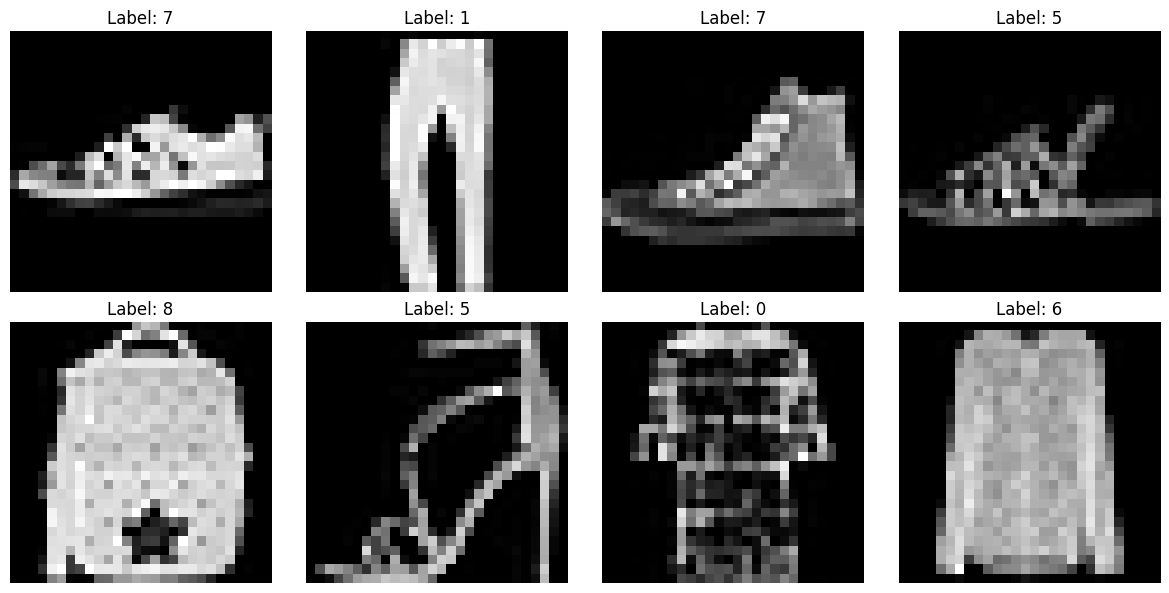

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select 8 random indices
random_indices = np.random.choice(df.index, size=8, replace=False)

# Get the images and labels for the selected indices
random_images = df.loc[random_indices, df.columns != 'label'].values
random_labels = df.loc[random_indices, 'label'].values

# Reshape the images to 28x28
random_images = random_images.reshape(-1, 28, 28)

# Display the images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(random_images[i], cmap='gray')
    plt.title(f"Label: {random_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
display(df['label'].value_counts().sort_index())

,count
label,
0,6000
1,6000
2,6000
3,6000
4,6000
5,6000
6,6000
7,6000
8,6000


In [9]:
# test train split

x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
# transform data for vgg16

from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
# create customdataset class

from PIL import Image
import numpy as np

class CustomDataset(Dataset):
  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to 28x28
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.astype(np.uint8)

    # change black&white to color
    image = np.stack([image]*3, axis = -1)

    # convert array to PIL
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return index and label
    return image, torch.tensor(self.labels[index], dtype=torch.long)

In [25]:
# create train_dataset object

train_dataset = CustomDataset(x_train, y_train, transform=custom_transform)

In [26]:
len(train_dataset)
train_dataset.__getitem__(0)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [27]:
# create test_dataset object

test_dataset = CustomDataset(x_test, y_test, transform=custom_transform)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
# fetch the pretrained model

import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 79.0MB/s]


In [30]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
for param in vgg16.features.parameters():
  param.requires_grad = False

In [33]:
vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)
)

In [34]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [35]:
vgg16 = vgg16.to(device)

In [36]:
epochs = 10
learning_rate = 0.0001

In [37]:
# instatntiate loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [38]:
# print number of batches
len(train_loader)

1500

In [40]:
for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # forward pass
    outputs = vgg16(batch_features)

    # calcultae loss
    loss = criterion(outputs, batch_labels)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f"Epoch: {epoch+1}, Loss: {avg_loss}")

Epoch: 1, Loss: 0.24585828232392667
Epoch: 2, Loss: 0.17501132846158
Epoch: 3, Loss: 0.13306900021294132
Epoch: 4, Loss: 0.09971489251129484
Epoch: 5, Loss: 0.07326858528105852
Epoch: 6, Loss: 0.05722541315634832
Epoch: 7, Loss: 0.046423395682119006
Epoch: 8, Loss: 0.039461378891418764
Epoch: 9, Loss: 0.03142990915041325
Epoch: 10, Loss: 0.028573532048900233


In [41]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
len(test_loader)

188

In [42]:
# evaluation code

total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = vgg16(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()

print(f"Accuracy on test: {correct/total}")

# evaluation on training data

total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = vgg16(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()

print(f"Accuracy on train: {correct/total}")

Accuracy on test: 0.9284166666666667
Accuracy on train: 0.9972708333333333
